# OR7230 Project -- Exploratory Analysis of Bank Queues

## Name : Yue Pang

In [1]:
import simpy
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from simpy.util import start_delayed
from mpl_toolkits import mplot3d
import seaborn as sns

# PART 1 : Import data

In [2]:
df = pd.read_csv('bank.csv')

In [3]:
df

,Number,Time,X2
0,1,0,26
1,2,60,24
2,3,60,28
3,4,60,28
4,5,180,24
...,...,...,...
150,151,39120,28
151,152,39180,24
152,153,39300,29
153,154,39360,26


# Part 2 : Data Preprocessing

In [4]:
df_groupby = df.groupby('Time')['Time'].count()

In [5]:
df_groupby

Time
0        1
60       3
180      1
240      4
300      1
        ..
39000    1
39120    1
39180    1
39300    1
39360    2
Name: Time, Length: 117, dtype: int64

In [6]:
# calculate arrival time
arr_time = [0]*len(df)
temp = []
row = df_groupby.shape[0]
l = 0

for i in range(row):
    temp.append(random.sample(range(0,60),df_groupby.iloc[i]))

for j in temp:
    j.sort()
    
    for k in j:
        arr_time[l] = k
        l = l + 1
        
time = df['Time'].to_list()
for i in range(len(time)):
    arr_time[i] = arr_time[i] + time[i]
        
        
df['Arrival Time']  = arr_time

In [7]:
df

,Number,Time,X2,Arrival Time
0,1,0,26,2
1,2,60,24,63
2,3,60,28,81
3,4,60,28,101
4,5,180,24,223
...,...,...,...,...
150,151,39120,28,39167
151,152,39180,24,39212
152,153,39300,29,39311
153,154,39360,26,39363


In [8]:
interarr_time = []
for i in range(0,len(arr_time)-1):
    temp = arr_time[i+1] - arr_time[i]
    interarr_time.append(temp)
interarr_time.append(0)
df['Interarrival Time'] = interarr_time

In [9]:
#calculate service time
ser_time = [i*60 for i in df['X2'].to_list()]
df['Service Time'] = ser_time

#df['Service Time'] = df['X2']

#ser_time = [i for i in df['Service Time'].to_list()]
#df['Service Time'] = ser_time

In [10]:
df.drop(['X2'],axis=1,inplace=True)
df

,Number,Time,Arrival Time,Interarrival Time,Service Time
0,1,0,2,61,1560
1,2,60,63,18,1440
2,3,60,81,20,1680
3,4,60,101,122,1680
4,5,180,223,19,1440
...,...,...,...,...,...
150,151,39120,39167,45,1680
151,152,39180,39212,99,1440
152,153,39300,39311,52,1740
153,154,39360,39363,39,1560


# Part 3 : Queueing system with changing number of service

In [11]:
#w = []
#wq = []
#exit = []

def source(env, df, counter):
    
    for i, row in df.iterrows():
        #c = client(env, 'Client%03d' % i, counter, row)
        c = client(env,i, counter, row)
        env.process(c)  
        t = row['Interarrival Time']
        yield env.timeout(t)

def client(env, no, counter, row):
   
    arrive = env.now # probably some changes to be done here
    #print('%s arrived at %7.4f' % (no,arrive))
    with counter.request() as req:
        results = yield req
        wait = env.now - arrive
        wq.append(wait)
        #print('%s waited %6.3f' % (no, wait))
        yield env.timeout(row['Service Time'])
        
        w.append(env.now - arrive)
        exit.append(env.now)
        #print('%s exited the office at %7.4f' % (no, env.now))

In [12]:
mean_w = []
mean_wq = []
exit = []

for i in range(1,21):
    wq = []
    w = []
    
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=i)
    env.process(source(env,df, counter))
    env.run()
    
    mean_w.append(round((np.mean(w))/60))
    mean_wq.append(round((np.mean(wq))/60))
    

In [13]:
result_model_1 = pd.DataFrame({'counter':range(1,21),'time in queue':mean_wq,'time in system':mean_w})

In [14]:
result_model_1

,counter,time in queue,time in system
0,1,1685.0,1711.0
1,2,678.0,704.0
2,3,343.0,369.0
3,4,175.0,201.0
4,5,75.0,101.0
5,6,31.0,57.0
6,7,15.0,41.0
7,8,8.0,34.0
8,9,5.0,31.0
9,10,3.0,29.0


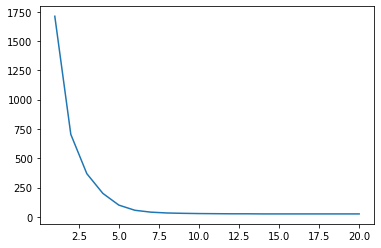

In [15]:
plt.plot(range(1,21),mean_w)

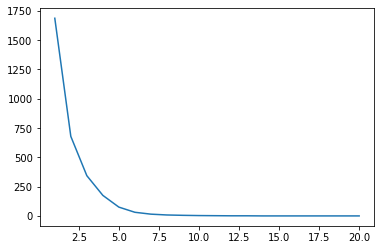

In [16]:
plt.plot(range(1,21),mean_wq)

# Part 4 : Queueing System with reneging customers

In [17]:
def source_rc(env, df, counter,patience):
    
    for i, row in df.iterrows():
        #c = client(env, 'Client%03d' % i, counter, row)
        c = client_rc(env,i, counter, row, patience)
        env.process(c)  
        t = row['Interarrival Time']
        yield env.timeout(t)

        
def client_rc(env, no, counter, row, patience):
   
    arrive = env.now # probably some changes to be done here
    #print('%s arrived at %7.4f' % (no,arrive))
    
    with counter.request() as req:
        results = yield req | env.timeout(patience)
        wait = env.now - arrive
        
        if req in results:
            #print('%7.4f %s: Waited %6.3f' % (env.now, no, wait))
            mean_wq.append(wait)
            
            yield env.timeout(row['Service Time'])
            mean_w.append(env.now - arrive)
            exit.append(env.now)
            #print('%s exited the office at %7.4f' % (no, env.now))
            
        else:
            
            leave.append(no)
            #print('%7.4f %s: RENEGED after %6.3f' % (env.now, no, wait))
            #print('Bank renege')

In [18]:
result_model_2 = np.empty(shape = (14*13,5))

In [19]:
plot_1 = np.empty(shape = (14,13))
plot_2 = np.empty(shape = (14,13))
plot_3 = np.empty(shape = (14,13))

In [20]:
l = 0
row = df.shape[0]

w_save = []
wq_save = []
leave_save = []

for i in range(1,15):#number of counter
    
    for j in range(13):#max waiting time
        max_wq = j*600
        mean_w = []
        mean_wq = []
        exit_time = []
        leave = []
        
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=i)
        env.process(source_rc(env, df,counter,max_wq))
        env.run()
        
        
        result_model_2[l][0] = i
        result_model_2[l][1] = max_wq
        result_model_2[l][2] = round((np.mean(mean_wq))/60)
        result_model_2[l][3] = round((np.mean(mean_w))/60)
        result_model_2[l][4] = round(len(leave)/row,4)
        
        plot_1[i-1][j] = round((np.mean(mean_wq))/60)
        plot_2[i-1][j] = round((np.mean(mean_w))/60)
        plot_3[i-1][j] = round(len(leave)/row,4)
        
        l = l+1
        
        
result_model_2 = pd.DataFrame(result_model_2,columns=['counter','max waiting time','mean time in queue',
                                                      'mean time in system','leave rate'])   

plot_1 = pd.DataFrame(plot_1,index=range(1,15),columns=[str(i*600) for i in range(13)])
plot_2 = pd.DataFrame(plot_2,index=range(1,15),columns=[str(i*600) for i in range(13)])
plot_3 = pd.DataFrame(plot_3,index=range(1,15),columns=[str(i*600) for i in range(13)])

In [21]:
result_model_2

,counter,max waiting time,mean time in queue,mean time in system,leave rate
0,1.0,0.0,0.0,26.0,0.9032
1,1.0,600.0,5.0,31.0,0.8710
2,1.0,1200.0,11.0,38.0,0.8710
3,1.0,1800.0,19.0,45.0,0.8323
4,1.0,2400.0,26.0,51.0,0.8258
...,...,...,...,...,...
177,14.0,4800.0,0.0,26.0,0.0000
178,14.0,5400.0,0.0,26.0,0.0000
179,14.0,6000.0,0.0,26.0,0.0000
180,14.0,6600.0,0.0,26.0,0.0000


In [22]:
plot_1

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,6000,6600,7200
1,0.0,5.0,11.0,19.0,26.0,35.0,43.0,52.0,62.0,72.0,79.0,88.0,96.0
2,0.0,5.0,11.0,19.0,24.0,33.0,43.0,49.0,60.0,69.0,77.0,88.0,94.0
3,0.0,4.0,10.0,17.0,22.0,31.0,40.0,48.0,56.0,66.0,72.0,84.0,91.0
4,0.0,4.0,10.0,16.0,20.0,28.0,34.0,39.0,48.0,59.0,68.0,72.0,83.0
5,0.0,3.0,9.0,14.0,17.0,21.0,31.0,33.0,42.0,51.0,53.0,59.0,66.0
6,0.0,3.0,8.0,12.0,15.0,18.0,24.0,27.0,30.0,31.0,31.0,31.0,31.0
7,0.0,3.0,6.0,10.0,12.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
8,0.0,2.0,5.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
9,0.0,1.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
10,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


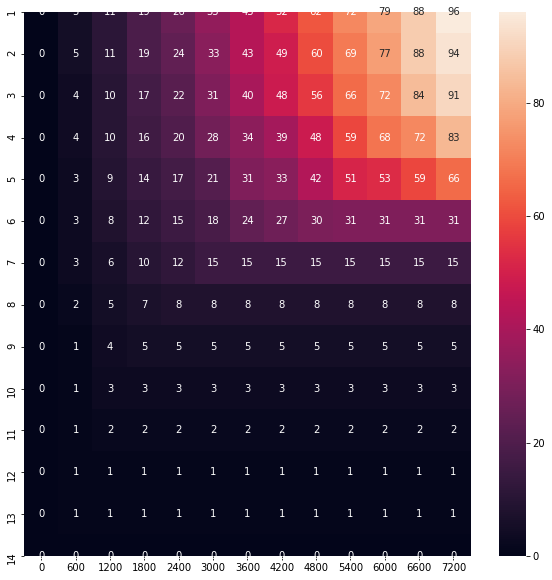

In [23]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_1,annot=True)

In [24]:
plot_2

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,6000,6600,7200
1,26.0,31.0,38.0,45.0,51.0,61.0,69.0,78.0,88.0,98.0,105.0,114.0,122.0
2,26.0,30.0,37.0,45.0,50.0,59.0,69.0,74.0,86.0,95.0,102.0,114.0,119.0
3,26.0,30.0,37.0,43.0,48.0,57.0,66.0,73.0,81.0,92.0,97.0,110.0,117.0
4,26.0,30.0,36.0,42.0,46.0,54.0,60.0,65.0,74.0,85.0,93.0,98.0,109.0
5,26.0,29.0,35.0,40.0,43.0,47.0,57.0,59.0,68.0,77.0,79.0,85.0,92.0
6,26.0,29.0,33.0,38.0,40.0,44.0,50.0,53.0,56.0,57.0,57.0,57.0,57.0
7,26.0,29.0,32.0,36.0,38.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0
8,26.0,28.0,31.0,33.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
9,26.0,27.0,30.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
10,26.0,27.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0


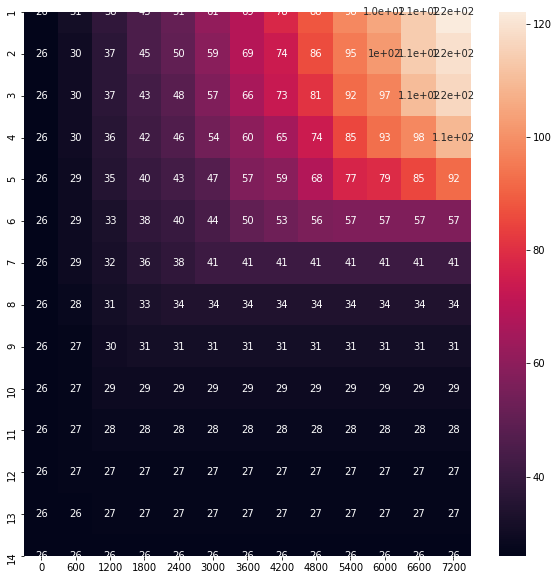

In [25]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_2,annot=True)

In [26]:
plot_3

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,6000,6600,7200
1,0.9032,0.8710,0.8710,0.8323,0.8258,0.8194,0.8194,0.8129,0.8129,0.8129,0.8065,0.8065,0.8000
2,0.8065,0.7419,0.7355,0.6774,0.6581,0.6452,0.6387,0.6323,0.6258,0.6194,0.6129,0.6129,0.6065
3,0.7161,0.6258,0.6000,0.5355,0.4903,0.4710,0.4581,0.4452,0.4387,0.4323,0.4258,0.4194,0.4129
4,0.6323,0.5097,0.4774,0.3871,0.3484,0.3161,0.2774,0.2710,0.2581,0.2452,0.2387,0.2323,0.2194
5,0.5484,0.4065,0.3484,0.2710,0.2323,0.2065,0.1355,0.1290,0.0839,0.0645,0.0581,0.0452,0.0258
6,0.4710,0.3032,0.2645,0.1677,0.1290,0.0968,0.0452,0.0258,0.0065,0.0000,0.0000,0.0000,0.0000
7,0.3935,0.2194,0.1935,0.0903,0.0323,0.0129,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.3161,0.1613,0.1032,0.0323,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.2516,0.1290,0.0387,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,0.2000,0.0903,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


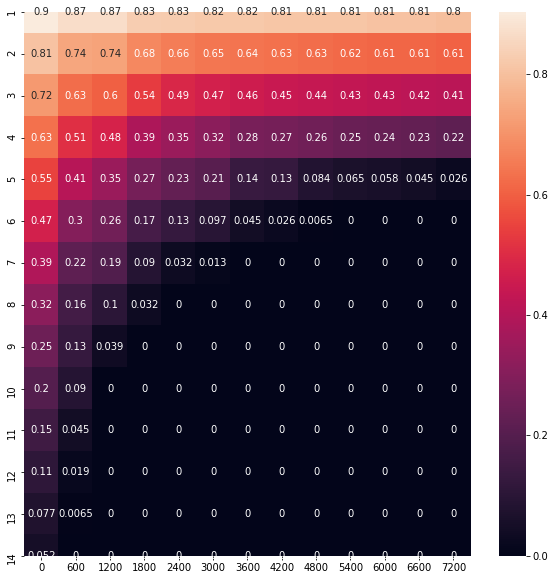

In [27]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_3,annot=True)

# Part 5 : Queueing System with balking customers

In [87]:
def source_bc(env,df,counter,maxInQueue):
    
    for i,row in df.iterrows():
        
        c = client_bc(env,i,counter,row,maxInQueue)
        #print(maxInQueue)
        #activate(c, c.visit(b=resource))
        env.process(c)
        t = row['Interarrival Time']
        #print(t)
        yield env.timeout(t)


def client_bc(env,no,counter,row,maxInQueue):
    arrive = env.now
    
    global num
    num = num + 1
    
    #print('%s arrived at %7.4f' % (no,arrive))
    
    with counter.request() as req:
        
        results = yield req
        

        if num <= maxInQueue:
            #yield counter
            wait = env.now - arrive
            #print('%s waited %6.3f' % (no, wait))
            model_3_wq.append(wait)
            
            yield env.timeout(row['Service Time'])
            #yield counter
            #num_list = num_list[:-1]            
            
            model_3_w.append(env.now - arrive)
            model_3_exit.append(env.now)
            #print('%s exited the office at %7.4f' % (no, env.now))
            
            #global num
            num = num - 1
        
        else:

            num = num - 1
            balking.append(no)
            
            #numBalking.append(1)  # 2
            #print("%8.4f %s: BALKING   " %(env.now, no))



In [88]:
result_model_3 = np.empty(shape = (14*10,5))

In [89]:
plot_3_wq = np.empty(shape = (14,10))
plot_3_w = np.empty(shape = (14,10))
plot_3_lr = np.empty(shape = (14,10))

In [90]:
l = 0
row = df.shape[0]


for i in range(1,15):#number of counter
    
    for j in range(1,11):#max queue length
        
        model_3_w = []
        model_3_wq = []
        model_3_exit = []
        balking = []
        num = 0
        
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=i)
        env.process(source_bc(env,df,counter,maxInQueue = j))
        env.run()
        
        
        result_model_3[l][0] = i
        result_model_3[l][1] = j
        result_model_3[l][2] = round((np.mean(model_3_wq))/60)
        result_model_3[l][3] = round((np.mean(model_3_w))/60)
        result_model_3[l][4] = round(len(balking)/row,4)
        
        plot_3_wq[i-1][j-1] = round((np.mean(model_3_wq))/60)
        plot_3_w[i-1][j-1] = round((np.mean(model_3_w))/60)
        plot_3_lr[i-1][j-1] = round(len(balking)/row,4)
        
        l = l+1
        
        
result_model_3 = pd.DataFrame(result_model_3,columns=['counter','max queue length','mean time in queue',
                                                      'mean time in system','leave rate'])   

plot_3_wq = pd.DataFrame(plot_3_wq,index=range(1,15),columns=[i for i in range(1,11)])
plot_3_w = pd.DataFrame(plot_3_w,index=range(1,15),columns=[i for i in range(1,11)])
plot_3_lr = pd.DataFrame(plot_3_lr,index=range(1,15),columns=[i for i in range(1,11)])

In [91]:
result_model_3

,counter,max queue length,mean time in queue,mean time in system,leave rate
0,1.0,1.0,6.0,32.0,0.8387
1,1.0,2.0,13.0,39.0,0.8258
2,1.0,3.0,22.0,48.0,0.8129
3,1.0,4.0,28.0,54.0,0.8065
4,1.0,5.0,35.0,61.0,0.7935
...,...,...,...,...,...
135,14.0,6.0,0.0,26.0,0.4710
136,14.0,7.0,0.0,26.0,0.3935
137,14.0,8.0,0.0,26.0,0.3161
138,14.0,9.0,0.0,26.0,0.2516


In [93]:
plot_3_wq

,1,2,3,4,5,6,7,8,9,10
1,6.0,13.0,22.0,28.0,35.0,39.0,46.0,52.0,66.0,69.0
2,0.0,2.0,7.0,12.0,17.0,24.0,30.0,34.0,38.0,42.0
3,0.0,0.0,1.0,4.0,7.0,11.0,16.0,22.0,25.0,29.0
4,0.0,0.0,0.0,1.0,3.0,6.0,8.0,11.0,15.0,18.0
5,0.0,0.0,0.0,0.0,1.0,2.0,4.0,6.0,8.0,10.0
6,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,6.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


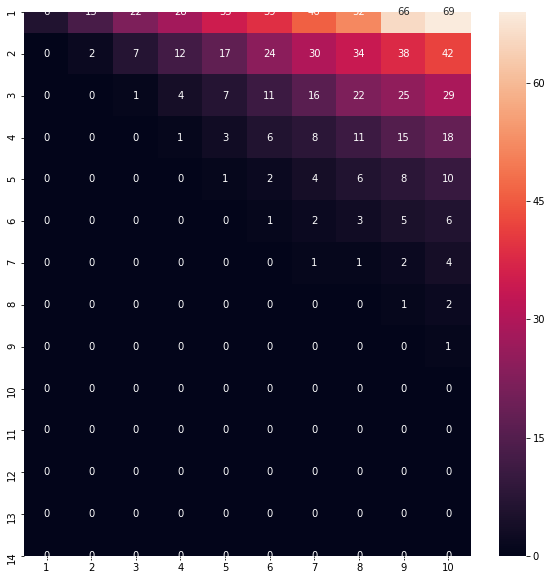

In [98]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_3_wq,annot=True)

In [94]:
plot_3_w

,1,2,3,4,5,6,7,8,9,10
1,32.0,39.0,48.0,54.0,61.0,65.0,72.0,78.0,92.0,95.0
2,26.0,28.0,32.0,38.0,43.0,50.0,56.0,59.0,64.0,69.0
3,26.0,26.0,27.0,30.0,33.0,37.0,42.0,48.0,51.0,55.0
4,26.0,26.0,26.0,27.0,29.0,32.0,34.0,37.0,41.0,44.0
5,26.0,26.0,26.0,26.0,27.0,28.0,30.0,32.0,34.0,36.0
6,26.0,26.0,26.0,26.0,26.0,27.0,28.0,29.0,31.0,32.0
7,26.0,26.0,26.0,26.0,26.0,26.0,27.0,27.0,29.0,30.0
8,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,27.0,28.0
9,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,27.0
10,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0


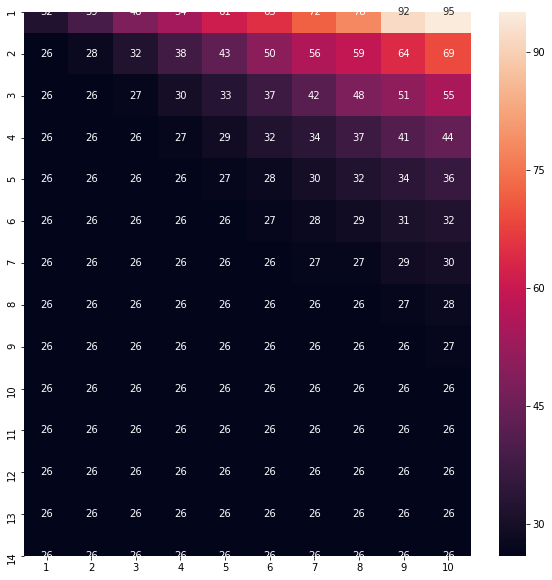

In [97]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_3_w,annot=True)

In [95]:
plot_3_lr

,1,2,3,4,5,6,7,8,9,10
1,0.8387,0.8258,0.8129,0.8065,0.7935,0.7935,0.7935,0.7806,0.7742,0.7742
2,0.9032,0.7419,0.6903,0.6710,0.6452,0.6323,0.6258,0.6194,0.6129,0.6065
3,0.9032,0.8065,0.6516,0.5935,0.5484,0.5161,0.4839,0.4774,0.4645,0.4516
4,0.9032,0.8065,0.7161,0.5677,0.5097,0.4581,0.4258,0.3806,0.3419,0.3355
5,0.9032,0.8065,0.7161,0.6323,0.4839,0.4323,0.3742,0.3355,0.3097,0.2710
6,0.9032,0.8065,0.7161,0.6323,0.5484,0.4065,0.3548,0.3032,0.2710,0.2387
7,0.9032,0.8065,0.7161,0.6323,0.5484,0.4710,0.3290,0.2839,0.2387,0.2129
8,0.9032,0.8065,0.7161,0.6323,0.5484,0.4710,0.3935,0.2581,0.2258,0.1871
9,0.9032,0.8065,0.7161,0.6323,0.5484,0.4710,0.3935,0.3161,0.2065,0.1742
10,0.9032,0.8065,0.7161,0.6323,0.5484,0.4710,0.3935,0.3161,0.2516,0.1548


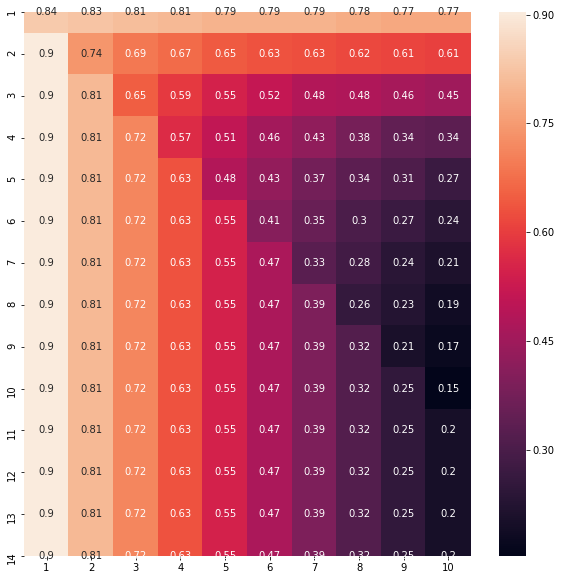

In [96]:
plt.figure(figsize = (10,10))
sns.heatmap(plot_3_lr,annot=True)